In [1]:
# install the DLOmix package in the current environment using pip
!python -m pip install -q dlomix==0.0.4
!python -m pip install wandb
import numpy as np
import pandas as pd
import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
import wandb
from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger
import wandb.apis.reports as wr
from dlomix.data import IntensityDataset
from dlomix.models import PrositIntensityPredictor
from dlomix.reports.postprocessing import normalize_intensity_predictions
import tensorflow as tf
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
import seaborn as sns
import plotly.express as px


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


wandb: Thanks for trying out the Report API!
wandb: For a tutorial, check out https://colab.research.google.com/drive/1CzyJx1nuOS4pdkXa2XPaRQyZdmFmLmXV
wandb: 
wandb: Try out tab completion to see what's available.
wandb:   ∟ everything:    `wr.<tab>`
wandb:       ∟ panels:    `wr.panels.<tab>`
wandb:       ∟ blocks:    `wr.blocks.<tab>`
wandb:       ∟ helpers:   `wr.helpers.<tab>`
wandb:       ∟ templates: `wr.templates.<tab>`
wandb:       
wandb: For bugs/feature requests, please create an issue on github: https://github.com/wandb/wandb/issues


In [74]:
class IntensityReport():

  def __init__(self, project:str, title: str, description: str, test_dataset: IntensityDataset, predictions):
    self.entity = wandb.apis.PublicApi().default_entity
    self.project = project
    self.title = title
    self.description = description
    self.predictions = predictions
    self.api = wandb.Api()
    self.test_dataset = test_dataset
    self.table_key_len = ""
    self.table_key_intensity = ""

  def create_report(self, add_config_section = True, add_train_section = True, add_val_section = True, add_train_val_section = True, 
                    add_spectral_angle_section = True):
    report = wr.Report(
        project = self.project,
        title = self.title,
        description = self.description
    )

    report.blocks = [
        wr.TableOfContents()
    ]
    if add_config_section:
      report.blocks += self.config_section()
    if add_train_section:
      report.blocks += self.train_section()
    if add_val_section:
      report.blocks += self.val_section()
    if add_train_val_section:
      report.blocks += self.train_val_section()
    if add_spectral_angle_section:
      report.blocks += self.spectral_angle_section()
    
    report.save()

  # get metrics of last run in project or from specified run_id
  def get_metrics(self, run_id = None):
    if run_id:
      # run is specified by <entity>/<project>/<run_id>
      run = self.api.run(path = f"{self.entity}/{self.project}/{run_id}")
      metrics_dataframe = run.history()
      return metrics_dataframe
    else:
      # get metrics of latest run
      # api.runs seems to have a delay
      runs = self.api.runs(path = f"{self.entity}/{self.project}")
      run = runs[0]
      metrics_dataframe = run.history()
      return metrics_dataframe

  # get metric names split into train/val, train is further split into batch/epoch
  def get_metrics_names(self):
    metrics = self.get_metrics()
    # filter strings from list that are not starting with "_" and do not contain "val"
    pre_filter = [string for string in metrics if not string.startswith("_")]
    batch_train_metrics_names = [string for string in pre_filter if ("val" not in string.lower()) & ("epoch" not in string.lower()) & ("table" not in string.lower())]
    epoch_train_metrics_names = [string for string in pre_filter if ("val" not in string.lower()) & ("batch" not in string.lower()) & ("table" not in string.lower())]
    # filter strings from list that contain "val"
    epoch_val_metrics_names = list(filter(lambda x: "val" in x.lower(), metrics))
    # filter strings from train metrics that are 'epoch/learning_rate' and 'epoch/epoch'
    strings_to_filter = ['epoch/learning_rate', 'epoch/epoch', 'batch/learning_rate', 'batch/batch_step']
    batch_train_metrics_names = [string for string in epoch_train_metrics_names if string not in strings_to_filter]
    epoch_train_metrics_names = [string for string in epoch_train_metrics_names if string not in strings_to_filter]
    return batch_train_metrics_names, epoch_train_metrics_names, epoch_val_metrics_names

  def get_train_val_metrics_names(self):
    _, epoch_train_metrics_names, epoch_val_metrics_names = self.get_metrics_names()
    epoch_train_metrics_names.sort()
    epoch_val_metrics_names.sort()
    return list(zip(epoch_train_metrics_names, epoch_val_metrics_names))
  
  def generate_intensity_results_df(self):
      predictions_df = pd.DataFrame()
      predictions_df['sequences'] = self.test_dataset.sequences
      predictions_df['intensities_pred'] = self.predictions.tolist()
      predictions_df['precursor_charge_onehot'] = self.test_dataset.precursor_charge.tolist()
      predictions_df['precursor_charge'] = np.argmax(self.test_dataset.precursor_charge, axis=1) + 1
      predictions_df['intensities_raw'] = self.test_dataset.intensities.tolist()
      predictions_df['collision_energy'] = self.test_dataset.collision_energy
      return predictions_df
  
  def log_spectral_angle_image(self):
    predictions_df = self.generate_intensity_results_df()
    predictions_acc = normalize_intensity_predictions(predictions_df, self.test_dataset.batch_size)
    violin_plot = sns.violinplot(data=predictions_acc, x="precursor_charge", y="spectral_angle")
    wb_table = pd.DataFrame()
    wb_table['spectral_angle'] = predictions_df['spectral_angle']
    wb_table['precursor_charge'] = predictions_df["precursor_charge"]
    table = wandb.Table(dataframe=wb_table)
    fig = violin_plot.get_figure()
    wandb.log({"chart": wandb.Image(fig), "table": table})

  def config_section(self):
    config_block = [
        wr.H1(text = "Config"),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels=[
            wr.RunComparer(layout = {'w': 24})
          ],
        ),
        wr.HorizontalRule(),
    ]
    return config_block

  def train_section(self):
    batch_train_metrics_names, epoch_train_metrics_names, _ = self.get_metrics_names()
    panel_list_batch = []
    panel_list_epoch = []
    if len(batch_train_metrics_names) > 3:
        width = 8
    else:
        width = 24 / len(batch_train_metrics_names)
    for name in batch_train_metrics_names:
      panel_list_batch.append(wr.LinePlot(x='Step', y=[name], layout={'w': width}))
    for name in epoch_train_metrics_names:
      panel_list_epoch.append(wr.LinePlot(x='Step', y=[name], layout={'w': width}))
    train_block = [
        wr.H1(text = "Training metrics"),
        wr.P("Lorem ipsum dolor sit amet. Aut laborum perspiciatis sit odit omnis aut aliquam voluptatibus ut rerum molestiae sed assumenda nulla ut minus illo sit sunt explicabo? Sed quia architecto est voluptatem magni sit molestiae dolores. Non animi repellendus ea enim internos et iste itaque quo labore mollitia aut omnis totam."),
        wr.H2(text = "per batch"),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels = panel_list_batch
        ),
        wr.H2(text = "per epoch"),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels = panel_list_epoch
        ),
        wr.HorizontalRule(),
    ]
    return train_block

  def val_section(self):
    _, _, epoch_val_metrics_names = self.get_metrics_names()
    panel_list_epoch = []
    if len(epoch_val_metrics_names) > 3:
        width = 8
    else:
        width = 24 / len(epoch_val_metrics_names)
    for name in epoch_val_metrics_names:
      panel_list_epoch.append(wr.LinePlot(x='Step', y=[name], layout={"w":width}))
    val_block = [
        wr.H1(text = "Validation metrics"),
        wr.P("Lorem ipsum dolor sit amet. Aut laborum perspiciatis sit odit omnis aut aliquam voluptatibus ut rerum molestiae sed assumenda nulla ut minus illo sit sunt explicabo? Sed quia architecto est voluptatem magni sit molestiae dolores. Non animi repellendus ea enim internos et iste itaque quo labore mollitia aut omnis totam."),
        wr.H2(text = "per epoch"),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels = panel_list_epoch
        ),
        wr.HorizontalRule(),
    ]
    return val_block

  def train_val_section(self):
    train_val_metrics_names = self.get_train_val_metrics_names()
    panel_list_epoch = []
    if len(train_val_metrics_names) > 3:
        width = 8
    else:
        width = 24 / len(train_val_metrics_names)
    for name in train_val_metrics_names:
      panel_list_epoch.append(wr.LinePlot(x='Step', y=list(name), layout={"w":width}))
    train_val_block = [
        wr.H1(text = "Train - Validation metrics"),
        wr.P("Lorem ipsum dolor sit amet. Aut laborum perspiciatis sit odit omnis aut aliquam voluptatibus ut rerum molestiae sed assumenda nulla ut minus illo sit sunt explicabo? Sed quia architecto est voluptatem magni sit molestiae dolores. Non animi repellendus ea enim internos et iste itaque quo labore mollitia aut omnis totam."),
        wr.H2(text = "per epoch"),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels = panel_list_epoch
        ),
        wr.HorizontalRule(),
    ]
    return train_val_block
  
  def spectral_angle_section(self):
    width = 24
    self.log_spectral_angle_image()
    spectral_angle_block = [
        wr.H1(text = "Spectral Angle"),
        wr.P("Lorem ipsum dolor sit amet. Aut laborum perspiciatis sit odit omnis aut aliquam voluptatibus ut rerum molestiae sed assumenda nulla ut minus illo sit sunt explicabo? Sed quia architecto est voluptatem magni sit molestiae dolores. Non animi repellendus ea enim internos et iste itaque quo labore mollitia aut omnis totam."),
        wr.PanelGrid(
          runsets=[
            wr.Runset(self.entity, self.project),
          ],
          panels = [wr.MediaBrowser(media_keys="chart", num_columns=1, layout= {"w": width})]
        ),
        wr.HorizontalRule(),
    ]
    return spectral_angle_block

In [68]:
# Create config
config = {
  "seq_length" : 30,
  "batch_size" : 64,
  "val_ratio" : 0.2,
  "lr" : 0.0001,
  "optimizer" : "ADAM",
  "loss" : "mse"
}

# Initialize WANDB
PROJECT = 'Demo_IntensityTimeReport'
RUN = "layout_3"
wandb.init(project = PROJECT, name = RUN, config = config)

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
batch/mse,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆███▇▇▇███▇▇▇▇▇▇▇▇▇▇
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/mse,▁█
epoch/val_loss,█▁
epoch/val_mse,▁█
batch/batch_step,737


In [69]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/tasks/intensity/example_datasets/Intensity/proteomeTools_train_val.csv'
BATCH_SIZE = 64

int_data = IntensityDataset(data_source=TRAIN_DATAPATH, seq_length=30, batch_size=BATCH_SIZE,
                            collision_energy_col='collision_energy', val_ratio=0.2, test=False)

In [70]:
model = PrositIntensityPredictor(seq_length=30)
tf.get_logger().setLevel('ERROR')
# create the optimizer object
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric
model.compile(optimizer=optimizer,
              loss=masked_spectral_distance,
              metrics=['mse',masked_pearson_correlation_distance])
history = model.fit(int_data.train_data,
                    validation_data=int_data.val_data,
                    epochs=2,callbacks=[WandbMetricsLogger(log_freq = "batch")])
# Mark the run as finished

Epoch 1/2
369/369 [==============================] - 90s 236ms/step - loss: 0.6058 - mse: 0.8335 - masked_pearson_correlation_distance: 0.4783 - val_loss: 0.5990 - val_mse: 0.8302 - val_masked_pearson_correlation_distance: 0.4671
Epoch 2/2
369/369 [==============================] - 88s 238ms/step - loss: 0.5721 - mse: 0.8930 - masked_pearson_correlation_distance: 0.4733 - val_loss: 0.5352 - val_mse: 0.8948 - val_masked_pearson_correlation_distance: 0.4444


In [71]:
# create the dataset object for test data

TEST_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix-resources/tasks/intensity/example_datasets/Intensity/proteomeTools_test.csv'

test_int_data = IntensityDataset(data_source=TEST_DATAPATH,
                              seq_length=30, collision_energy_col='collision_energy',batch_size=32, test=True)

# use model.predict from keras directly on the testdata

predictions = model.predict(test_int_data.test_data)


231/231 [==============================] - 11s 44ms/step


In [75]:
# Create a report
report = IntensityReport(project = "Demo_IntensityTimeReport",
                         title = "Comparison of different optimizers",
                         description = "Comparison of two optimizers Adam and RMSprop",
                         test_dataset = test_int_data,
                         predictions = predictions)

/Users/andi/PycharmProjects/dlomix_repo/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/andi/PycharmProjects/dlomix_repo/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/andi/PycharmProjects/dlomix_repo/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

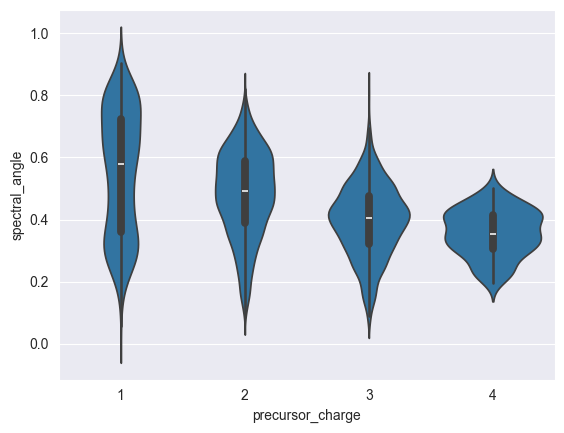

In [76]:
report.create_report()

In [ ]:
wandb.finish()